# Analysis on secondary dataset - Makaan

In [1]:
# !pip install --upgrade dtale
# !pip install --upgrade jinja2

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import re
import ast
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import dtale
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import FactorAnalysis
from statsmodels.stats.outliers_influence import variance_inflation_factor
from factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer import calculate_kmo
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import shapiro, levene
from statsmodels.stats.diagnostic import acorr_ljungbox

### Reading Dataset

In [3]:
df = pd.read_csv("Data/Major project - Sec_Data.csv")
df.head()

,Title,Address,Type,Floorsize,Carpet_area,Price_per_sqft,Price,Status,No_Of_Bathrooms,Is_new,Description,Facing,Furnishing_status,Locality,About_locality,Amenities_list
0,2088 sq ft West facing Plot for sale at Rs 10....,"Dadar West, Mumbai",Residential Plot,"2,088 sq ft",NaN,525/ sq ft the price/ sq ft of this property i...,1096200,Ready to move,NaN,New,A plot is available at a prime location in Dad...,West,Unfurnished,Dadar West,About locality: Dadar West9.9Locality ScoreDad...,['Wardrobe']
1,1089 sq ft South facing Plot for sale at Rs 2....,"Dadar West, Mumbai",Residential Plot,"1,089 sq ft",NaN,266/ sq ft the price/ sq ft of this property i...,290000,Ready to move,NaN,New,A plot is available at a prime location in Dad...,South,Unfurnished,Dadar West,About locality: Dadar West9.9Locality ScoreDad...,['Gymnasium']
2,1088 sq ft Completed property Plot for sale at...,"Bandra West, Mumbai",Residential Plot,"1,088 sq ft",NaN,"22,977/ sq ft the price/ sq ft of this propert...",25000000,Ready to move,NaN,Resale,This plot is situated in Bandra West. It has a...,NaN,Unfurnished,Bandra West,About locality: Bandra West9.8Locality ScoreBa...,"[""Children's play area""]"
3,7830 sq ft East facing Plot for sale at Rs 70....,"Bandra West, Mumbai",Residential Plot,"7,830 sq ft",NaN,"89,399/ sq ft the price/ sq ft of this propert...",700000000,Ready to move,NaN,New,Property located in Turner one of the premium ...,East,Unfurnished,Bandra West,About locality: Bandra West9.8Locality ScoreBa...,['Lift(s)']
4,6471 sq ft Completed property Plot for sale at...,"Bandra West, Mumbai",Residential Plot,"6,471 sq ft",NaN,"49,451/ sq ft the price/ sq ft of this propert...",320000000,Ready to move,NaN,New,"719 Square yard Plot for sale in Bandra West, ...",NaN,Unfurnished,Bandra West,About locality: Bandra West9.8Locality ScoreBa...,['AC']


### Data Cleaning

In [4]:
df.shape

(8882, 16)

### Dropping unnecessary columns

In [5]:
df.drop(columns=['Title'], inplace=True)

### Data types of each variable in data

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8882 entries, 0 to 8881
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Address            8882 non-null   object 
 1   Type               8882 non-null   object 
 2   Floorsize          8882 non-null   object 
 3   Carpet_area        6382 non-null   object 
 4   Price_per_sqft     8661 non-null   object 
 5   Price              8882 non-null   int64  
 6   Status             8882 non-null   object 
 7   No_Of_Bathrooms    6884 non-null   float64
 8   Is_new             7993 non-null   object 
 9   Description        8810 non-null   object 
 10  Facing             5367 non-null   object 
 11  Furnishing_status  8882 non-null   object 
 12  Locality           8882 non-null   object 
 13  About_locality     5226 non-null   object 
 14  Amenities_list     8881 non-null   object 
dtypes: float64(1), int64(1), object(13)
memory usage: 1.0+ MB


### Extracting and converting columns into required Type

In [7]:
df['Type'] = df['Type'].str.extract(r'(\d{1,2})').apply(pd.to_numeric)
df['Floorsize'] = df['Floorsize'].str.replace(',','').str.extract(r"(\d+)").apply(pd.to_numeric)
df['Carpet_area'] = df['Carpet_area'].str.extract(r"(\d+)").apply(pd.to_numeric)
df['Price_per_sqft'] = df['Price_per_sqft'].str.replace(',','').str.extract(r"(\d+)").apply(pd.to_numeric)
df['Area_rating'] = df['About_locality'].str.extract(r"(\d+.?\d{1})").apply(pd.to_numeric)

In [8]:
df.head(5)

,Address,Type,Floorsize,Carpet_area,Price_per_sqft,Price,Status,No_Of_Bathrooms,Is_new,Description,Facing,Furnishing_status,Locality,About_locality,Amenities_list,Area_rating
0,"Dadar West, Mumbai",NaN,2088,NaN,525.0,1096200,Ready to move,NaN,New,A plot is available at a prime location in Dad...,West,Unfurnished,Dadar West,About locality: Dadar West9.9Locality ScoreDad...,['Wardrobe'],9.9
1,"Dadar West, Mumbai",NaN,1089,NaN,266.0,290000,Ready to move,NaN,New,A plot is available at a prime location in Dad...,South,Unfurnished,Dadar West,About locality: Dadar West9.9Locality ScoreDad...,['Gymnasium'],9.9
2,"Bandra West, Mumbai",NaN,1088,NaN,22977.0,25000000,Ready to move,NaN,Resale,This plot is situated in Bandra West. It has a...,NaN,Unfurnished,Bandra West,About locality: Bandra West9.8Locality ScoreBa...,"[""Children's play area""]",9.8
3,"Bandra West, Mumbai",NaN,7830,NaN,89399.0,700000000,Ready to move,NaN,New,Property located in Turner one of the premium ...,East,Unfurnished,Bandra West,About locality: Bandra West9.8Locality ScoreBa...,['Lift(s)'],9.8
4,"Bandra West, Mumbai",NaN,6471,NaN,49451.0,320000000,Ready to move,NaN,New,"719 Square yard Plot for sale in Bandra West, ...",NaN,Unfurnished,Bandra West,About locality: Bandra West9.8Locality ScoreBa...,['AC'],9.8


In [9]:
# List of all amenities available in the amenities column

all_amenities = ['Full Power Backup',
 'Lift(s)',
 'Washing Machine',
 'Shopping Mall',
 'BED',
 'School',
 'Sports Facility',
 'TV',
 'Wifi',
 'Rain Water Harvesting',
 'Multipurpose Room',
 'Car Parking',
 'Jogging Track',
 'Refrigerator',
 'Staff Quarter',
 'Hospital',
 'Landscaped Gardens',
 'Cafeteria',
 'AC',
 '24 X 7 Security',
 "Children's play area",
 'Club House',
 'Sofa',
 'Indoor Games',
 'Dining Table',
 'Golf Course',
 'Gymnasium',
 'Maintenance Staff',
 'Wardrobe',
 'Swimming Pool',
 'Microwave',
 'Vaastu Compliant',
 'Gas connection',
 'ATM',
 'Intercom']

### Checking for null values

In [10]:
df.isna().sum()

Address                 0
Type                   14
Floorsize               0
Carpet_area          2500
Price_per_sqft        221
Price                   0
Status                  0
No_Of_Bathrooms      1998
Is_new                889
Description            72
Facing               3515
Furnishing_status       0
Locality                0
About_locality       3656
Amenities_list          1
Area_rating          4350
dtype: int64

In [11]:
# Dropping rows according to the columns floorsize and amenities
df = df.dropna(subset=['Floorsize','Amenities_list'])

In [12]:
df.isna().sum()

Address                 0
Type                   14
Floorsize               0
Carpet_area          2499
Price_per_sqft        221
Price                   0
Status                  0
No_Of_Bathrooms      1998
Is_new                889
Description            72
Facing               3514
Furnishing_status       0
Locality                0
About_locality       3655
Amenities_list          0
Area_rating          4349
dtype: int64

In [13]:
df.head()

,Address,Type,Floorsize,Carpet_area,Price_per_sqft,Price,Status,No_Of_Bathrooms,Is_new,Description,Facing,Furnishing_status,Locality,About_locality,Amenities_list,Area_rating
0,"Dadar West, Mumbai",NaN,2088,NaN,525.0,1096200,Ready to move,NaN,New,A plot is available at a prime location in Dad...,West,Unfurnished,Dadar West,About locality: Dadar West9.9Locality ScoreDad...,['Wardrobe'],9.9
1,"Dadar West, Mumbai",NaN,1089,NaN,266.0,290000,Ready to move,NaN,New,A plot is available at a prime location in Dad...,South,Unfurnished,Dadar West,About locality: Dadar West9.9Locality ScoreDad...,['Gymnasium'],9.9
2,"Bandra West, Mumbai",NaN,1088,NaN,22977.0,25000000,Ready to move,NaN,Resale,This plot is situated in Bandra West. It has a...,NaN,Unfurnished,Bandra West,About locality: Bandra West9.8Locality ScoreBa...,"[""Children's play area""]",9.8
3,"Bandra West, Mumbai",NaN,7830,NaN,89399.0,700000000,Ready to move,NaN,New,Property located in Turner one of the premium ...,East,Unfurnished,Bandra West,About locality: Bandra West9.8Locality ScoreBa...,['Lift(s)'],9.8
4,"Bandra West, Mumbai",NaN,6471,NaN,49451.0,320000000,Ready to move,NaN,New,"719 Square yard Plot for sale in Bandra West, ...",NaN,Unfurnished,Bandra West,About locality: Bandra West9.8Locality ScoreBa...,['AC'],9.8


### Converting amenities into list

In [14]:
df['Amenities_list'] = df['Amenities_list'].map(lambda x: sorted(ast.literal_eval(x)))

In [15]:
df['Amenities_list']

0                                              [Wardrobe]
1                                             [Gymnasium]
2                                  [Children's play area]
3                                               [Lift(s)]
4                                                    [AC]
                              ...                        
8877    [AC, BED, Dining Table, Full Power Backup, Gas...
8878    [AC, BED, Dining Table, Full Power Backup, Gas...
8879    [24 X 7 Security, ATM, Cafeteria, Car Parking,...
8880    [AC, BED, Dining Table, Full Power Backup, Gas...
8881    [24 X 7 Security, AC, BED, Cafeteria, Car Park...
Name: Amenities_list, Length: 8881, dtype: object

In [16]:
df.head()

,Address,Type,Floorsize,Carpet_area,Price_per_sqft,Price,Status,No_Of_Bathrooms,Is_new,Description,Facing,Furnishing_status,Locality,About_locality,Amenities_list,Area_rating
0,"Dadar West, Mumbai",NaN,2088,NaN,525.0,1096200,Ready to move,NaN,New,A plot is available at a prime location in Dad...,West,Unfurnished,Dadar West,About locality: Dadar West9.9Locality ScoreDad...,[Wardrobe],9.9
1,"Dadar West, Mumbai",NaN,1089,NaN,266.0,290000,Ready to move,NaN,New,A plot is available at a prime location in Dad...,South,Unfurnished,Dadar West,About locality: Dadar West9.9Locality ScoreDad...,[Gymnasium],9.9
2,"Bandra West, Mumbai",NaN,1088,NaN,22977.0,25000000,Ready to move,NaN,Resale,This plot is situated in Bandra West. It has a...,NaN,Unfurnished,Bandra West,About locality: Bandra West9.8Locality ScoreBa...,[Children's play area],9.8
3,"Bandra West, Mumbai",NaN,7830,NaN,89399.0,700000000,Ready to move,NaN,New,Property located in Turner one of the premium ...,East,Unfurnished,Bandra West,About locality: Bandra West9.8Locality ScoreBa...,[Lift(s)],9.8
4,"Bandra West, Mumbai",NaN,6471,NaN,49451.0,320000000,Ready to move,NaN,New,"719 Square yard Plot for sale in Bandra West, ...",NaN,Unfurnished,Bandra West,About locality: Bandra West9.8Locality ScoreBa...,[AC],9.8


### Avg percentage of floorarea with respect to carpetsize of the house

In [17]:
carpet_percent = (df['Carpet_area'] /df['Floorsize'])*100
carpet_percent.mean()

76.05685062965104

### Creating columns for all the amenities available (Total 35)

In [18]:
for a in all_amenities:
    df[a] = 0    

In [19]:
for index, row in df.iterrows():
    m = row['Amenities_list']
    
    for i in m:

        df.at[index,i] += 1      

In [20]:
df.head()

,Address,Type,Floorsize,Carpet_area,Price_per_sqft,Price,Status,No_Of_Bathrooms,Is_new,Description,...,Golf Course,Gymnasium,Maintenance Staff,Wardrobe,Swimming Pool,Microwave,Vaastu Compliant,Gas connection,ATM,Intercom
0,"Dadar West, Mumbai",NaN,2088,NaN,525.0,1096200,Ready to move,NaN,New,A plot is available at a prime location in Dad...,...,0,0,0,1,0,0,0,0,0,0
1,"Dadar West, Mumbai",NaN,1089,NaN,266.0,290000,Ready to move,NaN,New,A plot is available at a prime location in Dad...,...,0,1,0,0,0,0,0,0,0,0
2,"Bandra West, Mumbai",NaN,1088,NaN,22977.0,25000000,Ready to move,NaN,Resale,This plot is situated in Bandra West. It has a...,...,0,0,0,0,0,0,0,0,0,0
3,"Bandra West, Mumbai",NaN,7830,NaN,89399.0,700000000,Ready to move,NaN,New,Property located in Turner one of the premium ...,...,0,0,0,0,0,0,0,0,0,0
4,"Bandra West, Mumbai",NaN,6471,NaN,49451.0,320000000,Ready to move,NaN,New,"719 Square yard Plot for sale in Bandra West, ...",...,0,0,0,0,0,0,0,0,0,0


In [21]:
df.isna().sum()

Address                     0
Type                       14
Floorsize                   0
Carpet_area              2499
Price_per_sqft            221
Price                       0
Status                      0
No_Of_Bathrooms          1998
Is_new                    889
Description                72
Facing                   3514
Furnishing_status           0
Locality                    0
About_locality           3655
Amenities_list              0
Area_rating              4349
Full Power Backup           0
Lift(s)                     0
Washing Machine             0
Shopping Mall               0
BED                         0
School                      0
Sports Facility             0
TV                          0
Wifi                        0
Rain Water Harvesting       0
Multipurpose Room           0
Car Parking                 0
Jogging Track               0
Refrigerator                0
Staff Quarter               0
Hospital                    0
Landscaped Gardens          0
Cafeteria 

In [22]:
# Changing column names
df.columns = df.columns.str.replace(" ","_")

### Counts of all categories

In [23]:
for i in ['Status','Is_new','Facing','Furnishing_status','Locality']:
    print(df[i].value_counts())
    print("===========================================")

Ready to move         4788
Under Construction    4093
Name: Status, dtype: int64
New       4627
Resale    3365
Name: Is_new, dtype: int64
East         3098
West          941
NorthEast     504
North         396
SouthWest     151
NorthWest     134
South          83
SouthEast      60
Name: Facing, dtype: int64
Unfurnished       5908
Semi-Furnished    2292
Furnished          681
Name: Furnishing_status, dtype: int64
Nerul              495
Powai              489
Bandra West        476
Chembur            444
Byculla            429
Thane West         392
Parel              373
Kurla              370
Vikhroli           299
Dombivali          299
Goregaon West      268
Thane East         268
Kalyan East        268
Borivali East      266
Goregaon East      266
Bhandup West       266
Andheri West       266
Kalyan West        266
Ghatkopar West     264
Bandra East        264
Santacruz West     264
Borivali West      263
Santacruz East     262
Ghatkopar East     262
Sion               242
Mahalaxmi

In [24]:
df.isna().sum()

Address                     0
Type                       14
Floorsize                   0
Carpet_area              2499
Price_per_sqft            221
Price                       0
Status                      0
No_Of_Bathrooms          1998
Is_new                    889
Description                72
Facing                   3514
Furnishing_status           0
Locality                    0
About_locality           3655
Amenities_list              0
Area_rating              4349
Full_Power_Backup           0
Lift(s)                     0
Washing_Machine             0
Shopping_Mall               0
BED                         0
School                      0
Sports_Facility             0
TV                          0
Wifi                        0
Rain_Water_Harvesting       0
Multipurpose_Room           0
Car_Parking                 0
Jogging_Track               0
Refrigerator                0
Staff_Quarter               0
Hospital                    0
Landscaped_Gardens          0
Cafeteria 

### Avg value of price_per_sqft for new and resale properties

In [25]:
df[df['Is_new']  == "Resale"].mean()[3]

23016.837223587223

In [26]:
df[df['Is_new']  == "New"].mean()[3]

26359.985711145306

In [27]:
df['Is_new'].mode()

0    New
Name: Is_new, dtype: object

### Dropping the rows where in Type is Plot area

In [28]:
df.dropna(subset = ['Type'], inplace=True, axis=0)

In [29]:
df.reset_index(inplace=True)

In [30]:
df.drop(columns=['index'], inplace=True)

In [31]:
# df['Status'] = df['Status'].replace({'Under Construction':1, 'Ready to move':2})

### Dropping unnecessary columns

In [32]:
df.drop(columns=['Facing','Amenities_list','About_locality','Description','Is_new','Area_rating'], inplace=True)

### Replacing area name with appropirate value

In [33]:
df['Locality'].replace({'Borivali (West)':'Borivali West', 'Andheri (West)': 'Andheri West'}, inplace=True)

In [34]:
df.isna().sum()

Address                     0
Type                        0
Floorsize                   0
Carpet_area              2485
Price_per_sqft            221
Price                       0
Status                      0
No_Of_Bathrooms          1984
Furnishing_status           0
Locality                    0
Full_Power_Backup           0
Lift(s)                     0
Washing_Machine             0
Shopping_Mall               0
BED                         0
School                      0
Sports_Facility             0
TV                          0
Wifi                        0
Rain_Water_Harvesting       0
Multipurpose_Room           0
Car_Parking                 0
Jogging_Track               0
Refrigerator                0
Staff_Quarter               0
Hospital                    0
Landscaped_Gardens          0
Cafeteria                   0
AC                          0
24_X_7_Security             0
Children's_play_area        0
Club_House                  0
Sofa                        0
Indoor_Gam

### Filling missing values

In [35]:
# Carpet Area

df['Carpet_area'].fillna(df['Floorsize']*0.76, inplace=True)

In [36]:
# Price per sqft

df['Price_per_sqft'].fillna(df['Price']/df['Floorsize'], inplace=True)

In [37]:
# No. of bathrooms

df['No_Of_Bathrooms'].mode()

0    2.0
Name: No_Of_Bathrooms, dtype: float64

In [38]:
# Replacing with it's mode

# df['No_Of_Bathrooms'].fillna(2, inplace=True)

In [39]:
df = df.sort_values(by="Type")
df['No_Of_Bathrooms'] = np.ceil(df['No_Of_Bathrooms'].interpolate())


In [40]:
df.reset_index(inplace=True)

In [41]:
df.drop(columns='index', inplace=True)

In [42]:
df.to_excel('Data/Cleaned_16_05_23.xlsx')

In [43]:
# Checking fo nulls
df.isna().sum()

Address                  0
Type                     0
Floorsize                0
Carpet_area              0
Price_per_sqft           0
Price                    0
Status                   0
No_Of_Bathrooms          0
Furnishing_status        0
Locality                 0
Full_Power_Backup        0
Lift(s)                  0
Washing_Machine          0
Shopping_Mall            0
BED                      0
School                   0
Sports_Facility          0
TV                       0
Wifi                     0
Rain_Water_Harvesting    0
Multipurpose_Room        0
Car_Parking              0
Jogging_Track            0
Refrigerator             0
Staff_Quarter            0
Hospital                 0
Landscaped_Gardens       0
Cafeteria                0
AC                       0
24_X_7_Security          0
Children's_play_area     0
Club_House               0
Sofa                     0
Indoor_Games             0
Dining_Table             0
Golf_Course              0
Gymnasium                0
M

In [44]:
df['Price'] = df['Price'].astype(float)
df['Floorsize'] = df['Floorsize'].astype(float)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8867 entries, 0 to 8866
Data columns (total 45 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Address                8867 non-null   object 
 1   Type                   8867 non-null   float64
 2   Floorsize              8867 non-null   float64
 3   Carpet_area            8867 non-null   float64
 4   Price_per_sqft         8867 non-null   float64
 5   Price                  8867 non-null   float64
 6   Status                 8867 non-null   object 
 7   No_Of_Bathrooms        8867 non-null   float64
 8   Furnishing_status      8867 non-null   object 
 9   Locality               8867 non-null   object 
 10  Full_Power_Backup      8867 non-null   int64  
 11  Lift(s)                8867 non-null   int64  
 12  Washing_Machine        8867 non-null   int64  
 13  Shopping_Mall          8867 non-null   int64  
 14  BED                    8867 non-null   int64  
 15  Scho

## Exploratory Data Analysis

#### Univariate analysis

### Count plots

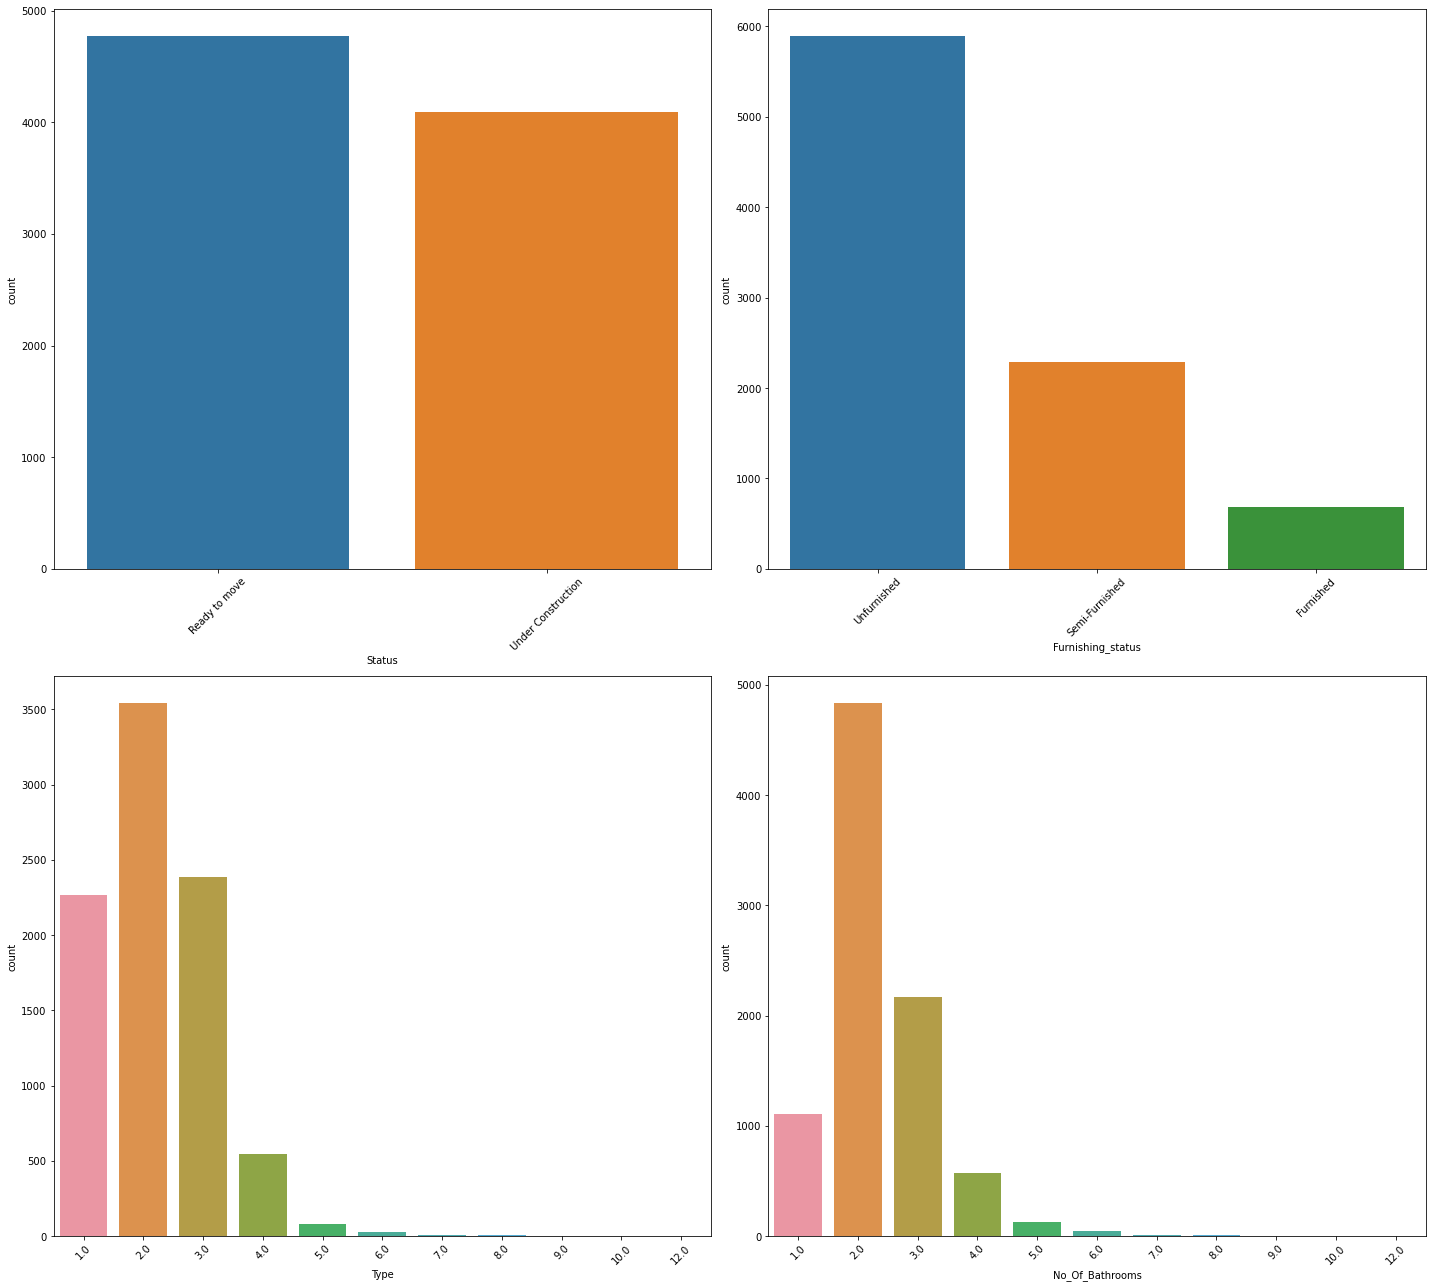

In [45]:
plt.figure(figsize = (20,18))
plt.subplot(2,2,1)
sns.countplot(df['Status'])
plt.xticks(rotation=45)
plt.subplot(2,2,2)
sns.countplot(df['Furnishing_status'])
plt.xticks(rotation=45)
plt.subplot(2,2,3)
sns.countplot(df['Type'])
plt.xticks(rotation=45)
plt.subplot(2,2,4)
sns.countplot(df['No_Of_Bathrooms'])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
# plt.subplot()

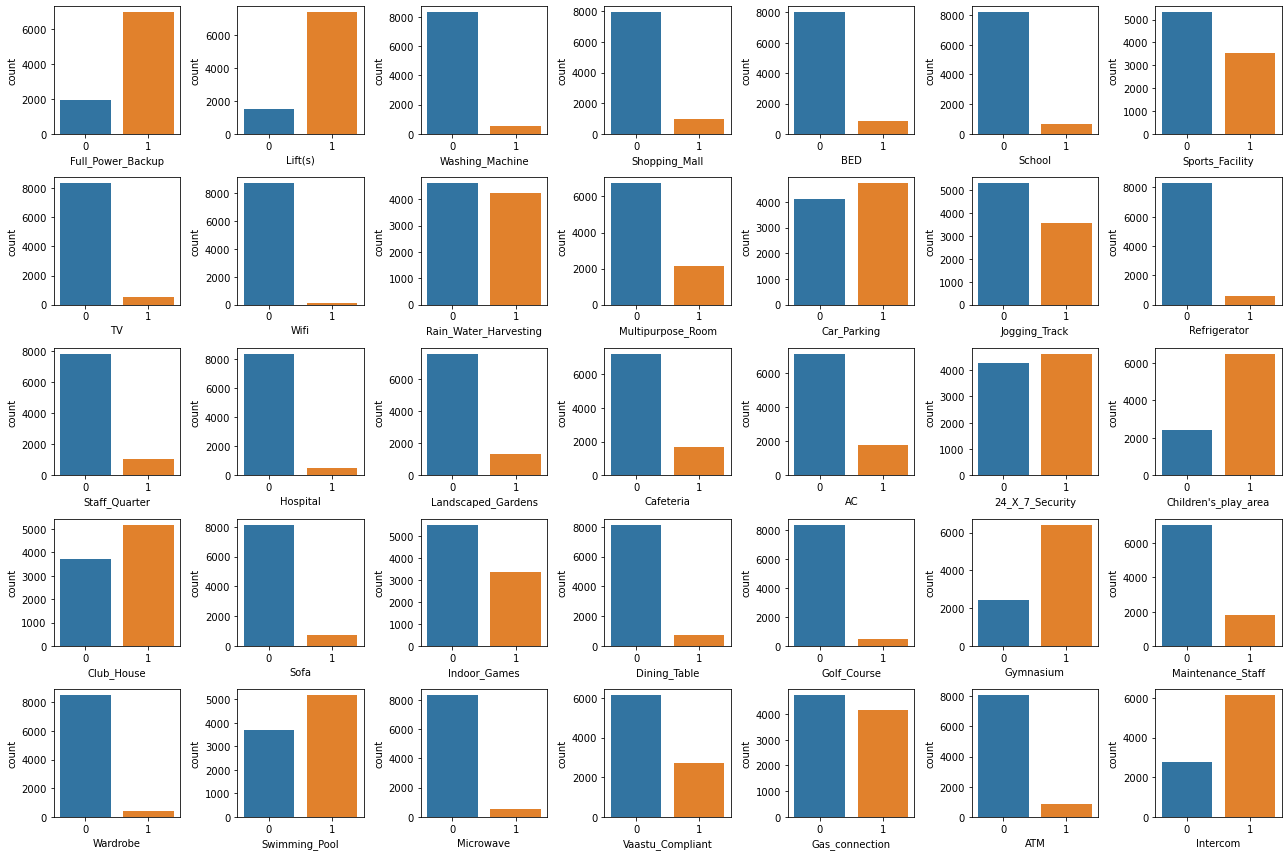

In [46]:
fig, axes = plt.subplots(nrows=5, ncols=7, figsize=(18, 12))

df_int = df.select_dtypes([np.int])
# Flatten the axes array so we can iterate over it easily
axes = axes.flatten()

# Loop through each subplot and plot a countplot
for i, ax in enumerate(axes):
    if i < len(df_int.columns):
        sns.countplot(x=df_int.columns[i], data=df_int, ax=ax)

# Adjust the spacing between subplots
fig.tight_layout()

# Display the plot
plt.show()


[]

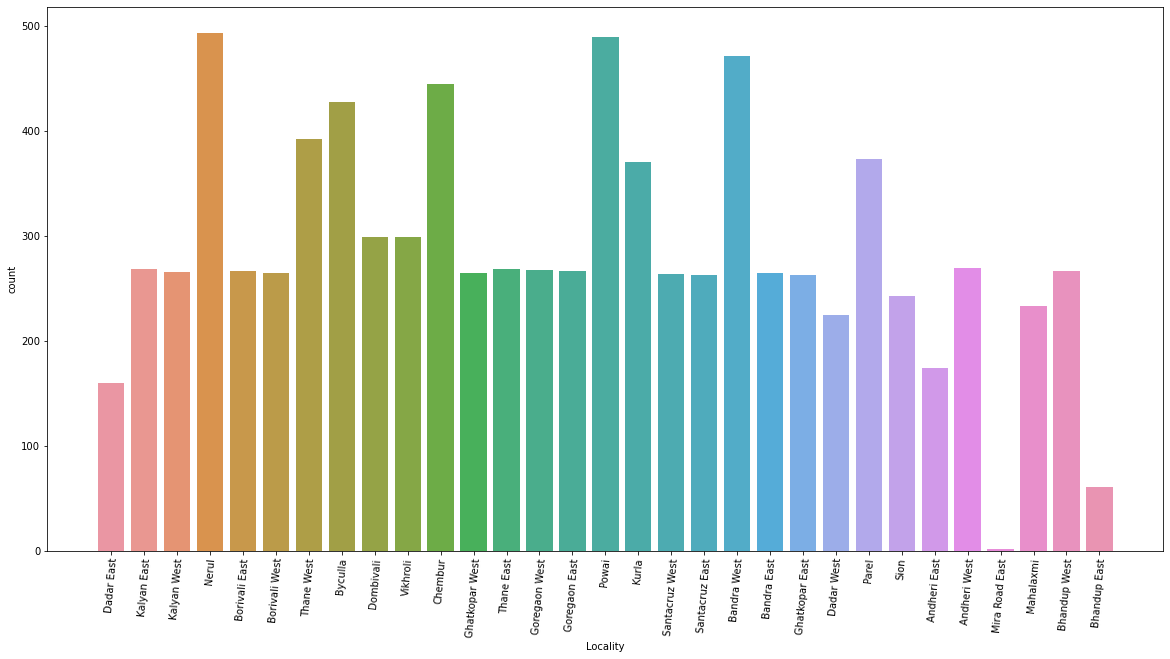

In [47]:
plt.figure(figsize = (20,10))
sns.countplot(df['Locality'])
plt.xticks(rotation=85)
plt.plot()

### Distribution of prices

<Figure size 864x576 with 0 Axes>

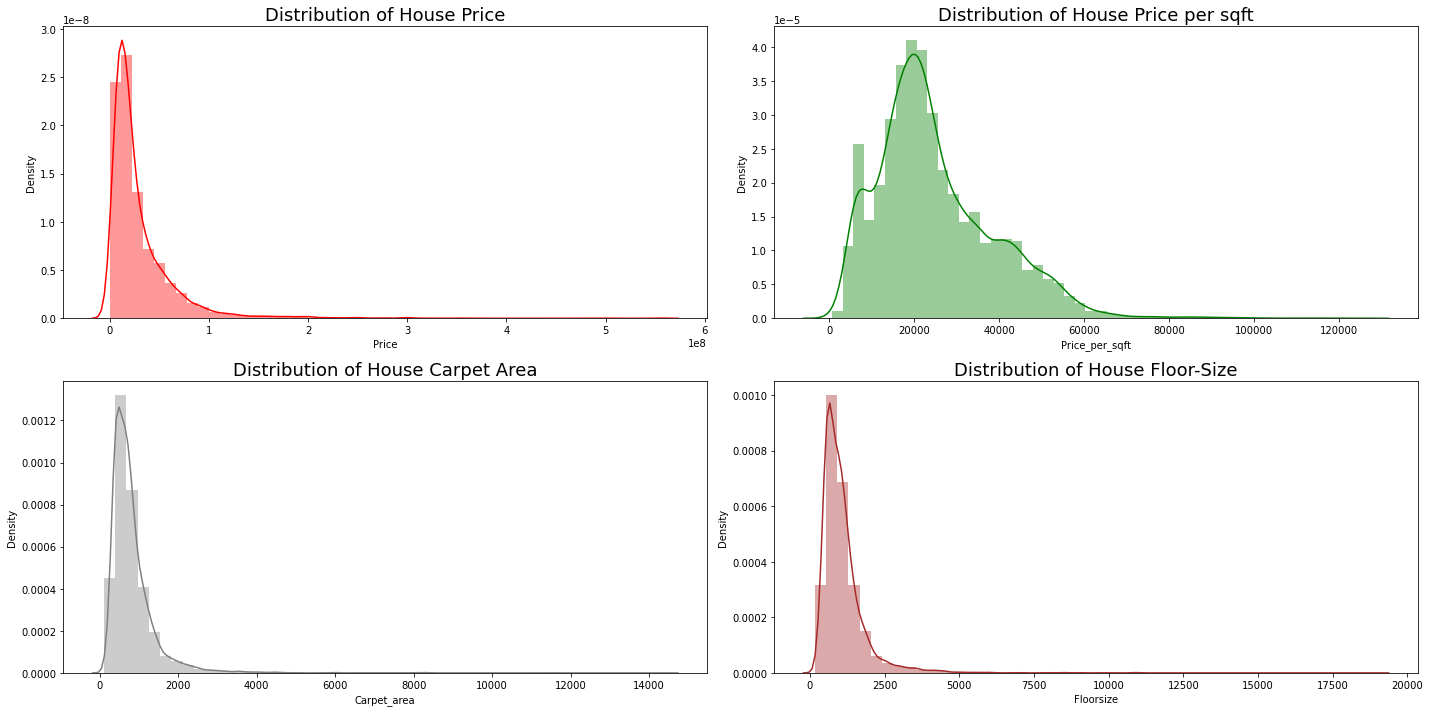

In [48]:
plt.figure(figsize=(12,8))

plt.figure(figsize = (20,10))
plt.subplot(2,2,1)
sns.distplot(df['Price'], color='red')
plt.title('Distribution of House Price', fontsize=18)


plt.subplot(2,2,2)
sns.distplot(df['Price_per_sqft'], color='green')
plt.title('Distribution of House Price per sqft', fontsize=18)

plt.subplot(2,2,3)
sns.distplot(df['Carpet_area'], color='gray')
plt.title('Distribution of House Carpet Area', fontsize=18)

plt.subplot(2,2,4)
sns.distplot(df['Floorsize'], color='brown')
plt.title('Distribution of House Floor-Size', fontsize=18)

plt.tight_layout()
plt.show()
# plt.subplot()

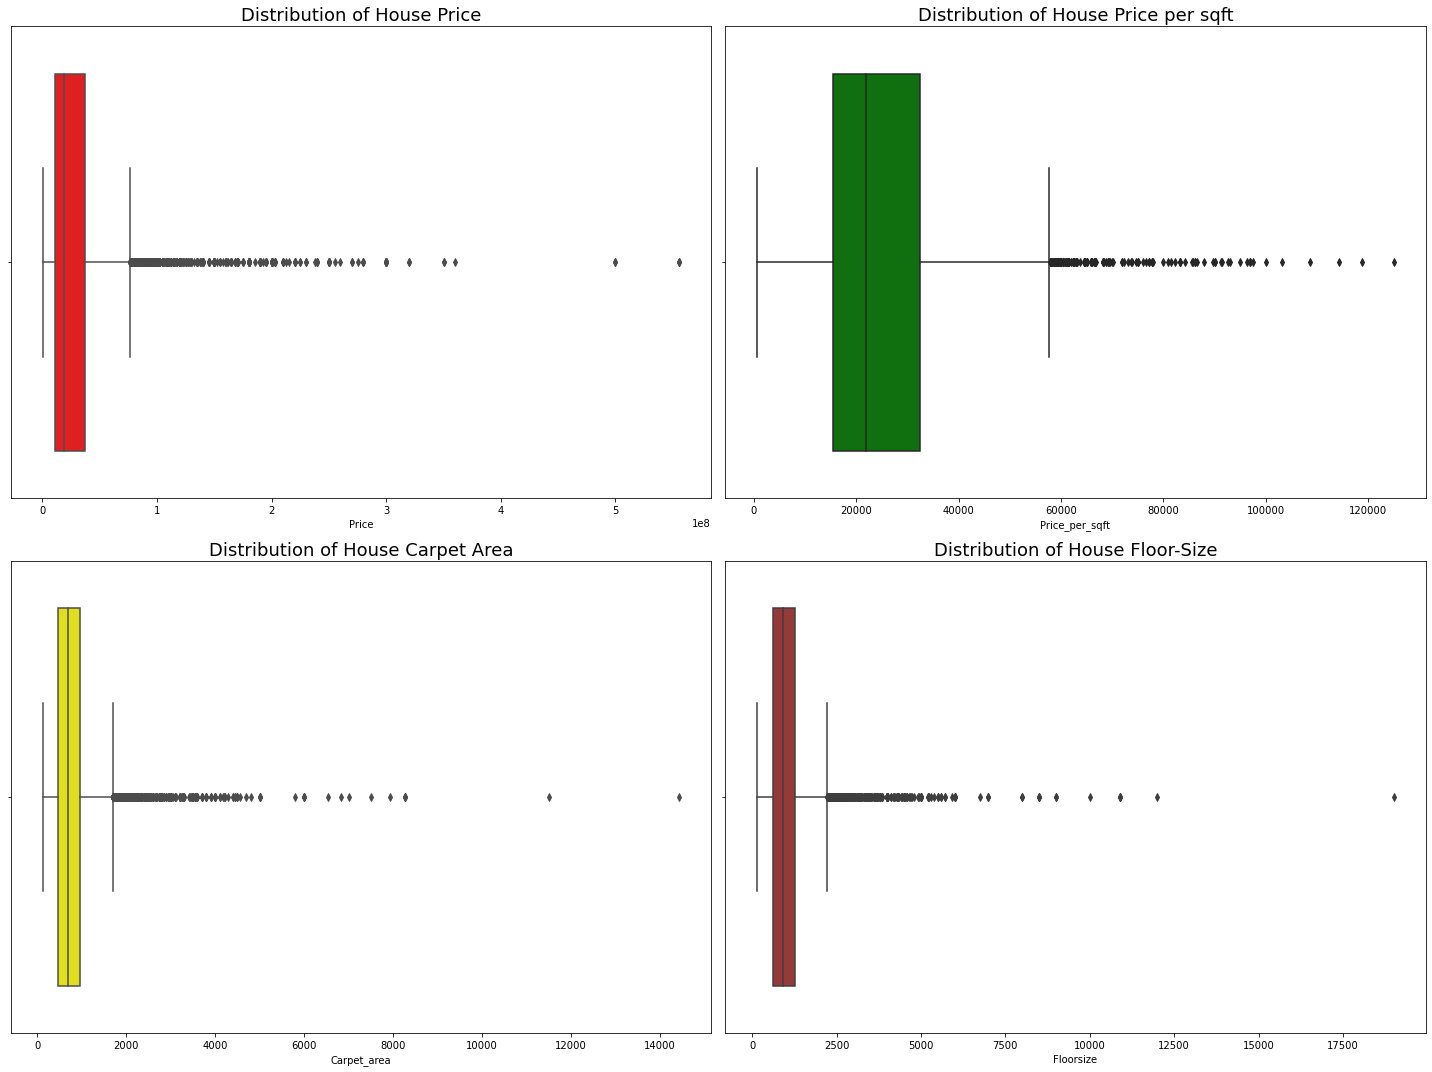

In [49]:
plt.figure(figsize=(20,15))

plt.subplot(2,2,1)
sns.boxplot(df['Price'], color='red')
plt.title('Distribution of House Price', fontsize=18)

plt.subplot(2,2,2)
sns.boxplot(df['Price_per_sqft'], color='green')
plt.title('Distribution of House Price per sqft', fontsize=18)

plt.subplot(2,2,3)
sns.boxplot(df['Carpet_area'], color='yellow')
plt.title('Distribution of House Carpet Area', fontsize=18)

plt.subplot(2,2,4)
sns.boxplot(df['Floorsize'], color='brown')
plt.title('Distribution of House Floor-Size', fontsize=18)

plt.tight_layout()
plt.show()
# plt.subplot()

#### Bivariate Analysis

In [50]:
# To check for normality

from scipy.stats import norm

# norm = a normal continous variable.

# log_style = np.log(train['SalePrice'])  # log of salesprice

# fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(14,10))
# plt.suptitle('Probability Plots', fontsize=18)
# ax1 = sns.distplot(train['SalePrice'], color="#FA5858", ax=ax1, fit=norm)
# ax1.set_title("Distribution of Sales Price with Positive Skewness", fontsize=14)
# ax2 = sns.distplot(log_style, color="#58FA82",ax=ax2, fit=norm)
# ax2.set_title("Normal Distibution with Log Transformations", fontsize=14)
# ax3 = stats.probplot(train['SalePrice'], plot=ax3)
# ax4 = stats.probplot(log_style, plot=ax4)

# plt.show()


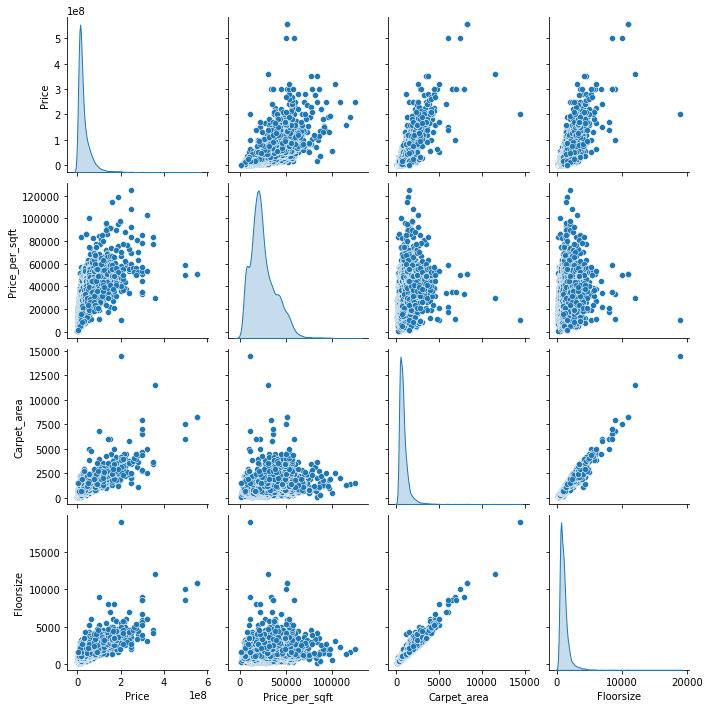

In [51]:
sns.pairplot(df[['Price','Price_per_sqft','Carpet_area','Floorsize']],diag_kind='kde')

### Checking multicollinearity between each variables

In [52]:
cor_mat = (df.corr())

[]

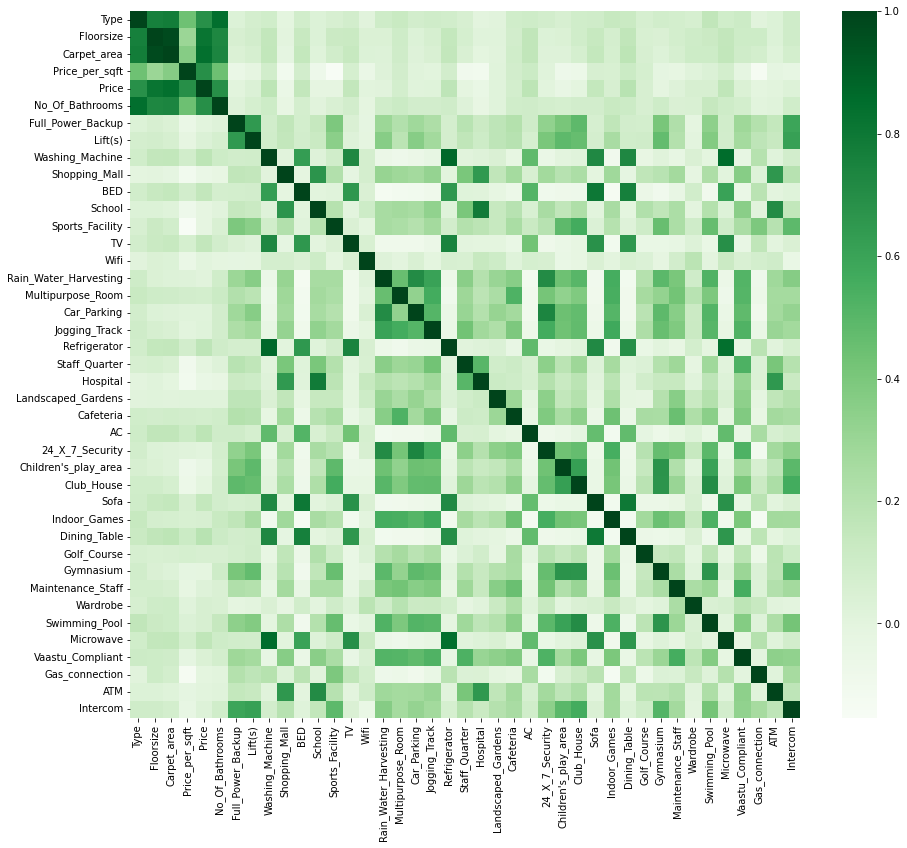

In [53]:
plt.figure(figsize=(15,13))
corr_plot = sns.heatmap(cor_mat,cmap="Greens")
plt.plot()

In [54]:

# Set the desired figure size (optional)
corr_plot.figure.set_size_inches(20,20)

# Save the plot in high resolution
corr_plot.figure.savefig("corr_plot_secondary.png", dpi=300)

In [55]:
df.isna().sum()

Address                  0
Type                     0
Floorsize                0
Carpet_area              0
Price_per_sqft           0
Price                    0
Status                   0
No_Of_Bathrooms          0
Furnishing_status        0
Locality                 0
Full_Power_Backup        0
Lift(s)                  0
Washing_Machine          0
Shopping_Mall            0
BED                      0
School                   0
Sports_Facility          0
TV                       0
Wifi                     0
Rain_Water_Harvesting    0
Multipurpose_Room        0
Car_Parking              0
Jogging_Track            0
Refrigerator             0
Staff_Quarter            0
Hospital                 0
Landscaped_Gardens       0
Cafeteria                0
AC                       0
24_X_7_Security          0
Children's_play_area     0
Club_House               0
Sofa                     0
Indoor_Games             0
Dining_Table             0
Golf_Course              0
Gymnasium                0
M

In [56]:
df['Locality'] = df['Locality'].str.replace(" ","")

In [57]:
df['Locality'] = df['Locality'].str.replace('West|East','')

In [58]:
df['Locality'] = df['Locality'].replace({'MiraRoad':'Thane'})

In [59]:
sorted_by_count = df['Locality'].value_counts().index
sorted_by_count

Index(['Bandra', 'Thane', 'Goregaon', 'Kalyan', 'Borivali', 'Ghatkopar',
       'Santacruz', 'Nerul', 'Powai', 'Chembur', 'Andheri', 'Byculla', 'Dadar',
       'Parel', 'Kurla', 'Bhandup', 'Vikhroli', 'Dombivali', 'Sion',
       'Mahalaxmi'],
      dtype='object')

In [60]:
dict_replace = {sorted_by_count[i]:i  for i in range(len(sorted_by_count))}
dict_replace

{'Bandra': 0,
 'Thane': 1,
 'Goregaon': 2,
 'Kalyan': 3,
 'Borivali': 4,
 'Ghatkopar': 5,
 'Santacruz': 6,
 'Nerul': 7,
 'Powai': 8,
 'Chembur': 9,
 'Andheri': 10,
 'Byculla': 11,
 'Dadar': 12,
 'Parel': 13,
 'Kurla': 14,
 'Bhandup': 15,
 'Vikhroli': 16,
 'Dombivali': 17,
 'Sion': 18,
 'Mahalaxmi': 19}

In [61]:
df['Locality'] = df['Locality'].replace(dict_replace)

In [62]:
df.drop(columns=['Address'],inplace=True)

In [63]:
for i in df.select_dtypes([np.object]):
    print(df[i].value_counts())
    print("============================")

Ready to move         4774
Under Construction    4093
Name: Status, dtype: int64
Unfurnished       5894
Semi-Furnished    2292
Furnished          681
Name: Furnishing_status, dtype: int64


In [64]:
df['Status'] = df['Status'].replace({'Under Construction':0,'Ready to move': 1})
df['Furnishing_status'] = df['Furnishing_status'].replace({'Unfurnished':0, 'Semi-Furnished':1, 'Furnished':2})

### Final data for building models

In [65]:
df.head()

,Type,Floorsize,Carpet_area,Price_per_sqft,Price,Status,No_Of_Bathrooms,Furnishing_status,Locality,Full_Power_Backup,...,Golf_Course,Gymnasium,Maintenance_Staff,Wardrobe,Swimming_Pool,Microwave,Vaastu_Compliant,Gas_connection,ATM,Intercom
0,1.0,500.0,411.0,40000.0,20000000.0,1,2.0,0,12,1,...,0,0,0,0,0,0,0,1,0,1
1,1.0,515.0,480.0,4271.0,2200000.0,1,1.0,1,3,0,...,0,0,0,1,0,0,0,0,0,0
2,1.0,750.0,490.0,6266.0,4700000.0,0,2.0,0,3,1,...,0,0,0,0,0,0,1,0,1,0
3,1.0,640.0,448.0,5000.0,3200000.0,0,2.0,0,3,0,...,0,0,0,0,1,0,0,0,0,0
4,1.0,661.0,490.0,6959.0,4600000.0,0,2.0,0,3,1,...,0,1,0,0,1,0,1,1,0,1


In [66]:
df.to_excel('Data/Cleaned_16_05_23.xlsx')

## Factor Analysis

In [67]:
df_fa_X = df.loc[:,'Full_Power_Backup':]

In [68]:
df_fa_X.head()

,Full_Power_Backup,Lift(s),Washing_Machine,Shopping_Mall,BED,School,Sports_Facility,TV,Wifi,Rain_Water_Harvesting,...,Golf_Course,Gymnasium,Maintenance_Staff,Wardrobe,Swimming_Pool,Microwave,Vaastu_Compliant,Gas_connection,ATM,Intercom
0,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,1,1,0,1,0,1,0,0,0,1,...,0,0,0,0,0,0,1,0,1,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,1,1,0,1,0,0,1,0,0,0,...,0,1,0,0,1,0,1,1,0,1


In [69]:
vif_data = pd.DataFrame()
vif_data["Feature"] = df_fa_X.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(df_fa_X.values, i)
                          for i in range(len(df_fa_X.columns))]
  
vif_data

,Feature,VIF
0,Full_Power_Backup,9.126685
1,Lift(s),11.852466
2,Washing_Machine,6.298539
3,Shopping_Mall,2.571713
4,BED,3.908810
5,School,3.872729
6,Sports_Facility,3.235586
7,TV,2.915148
8,Wifi,1.128774
9,Rain_Water_Harvesting,5.506987


### Test to check for fit of data for FA

In [70]:
chi_sq, p_value = calculate_bartlett_sphericity(df_fa_X)
chi_sq
print("Chi_sq: {}, p-value: {}".format(chi_sq, p_value))

Chi_sq: 194390.10552845642, p-value: 0.0


In [71]:
kmo_all,kmo_model=calculate_kmo(df_fa_X)

In [72]:
kmo_model

0.9205124119758122

### Applying FA & Getting eigen value

In [73]:
from factor_analyzer import FactorAnalyzer

fa = FactorAnalyzer()
fa.fit(df_fa_X)

# Check Eigenvalues
ev, v = fa.get_eigenvalues()
ev

array([8.80986254, 5.85609824, 2.82604421, 2.04211656, 1.46978142,
       1.21604234, 1.07929981, 1.00267439, 0.91336983, 0.77944264,
       0.7266558 , 0.65869872, 0.59126176, 0.55631944, 0.54001342,
       0.48173198, 0.42487596, 0.41177067, 0.39063097, 0.37766775,
       0.3595339 , 0.34412162, 0.33358765, 0.32739903, 0.31064614,
       0.2981492 , 0.28629521, 0.25563606, 0.24644273, 0.23438616,
       0.2243533 , 0.17986906, 0.17351098, 0.1533794 , 0.11833114])

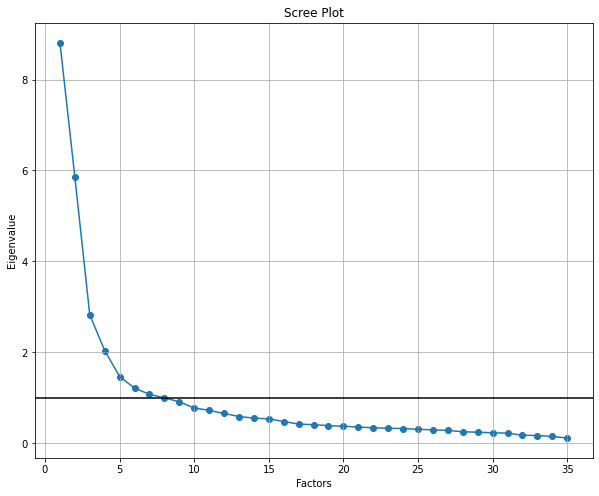

In [74]:
plt.figure(figsize=(10,8))
plt.scatter(range(1,df_fa_X.shape[1]+1),ev)
plt.plot(range(1,df_fa_X.shape[1]+1),ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.axhline(y=1,c='k')
plt.show()

### Loading Matrix

In [75]:
fa_v = FactorAnalyzer(8, rotation="varimax")
fa_v.fit(df_fa_X)
loadsvarimax = fa_v.loadings_
loadsvarimax_data = pd.DataFrame(loadsvarimax)
loadsvarimax_data.head()

,0,1,2,3,4,5,6,7
0,0.080495,0.316745,0.071684,0.077444,0.684176,0.013120,0.139878,0.065623
1,0.084251,0.398700,0.051684,0.045043,0.702653,0.012389,0.011683,0.020641
2,0.892963,0.066540,0.008650,-0.045256,-0.024512,0.078731,0.047121,-0.075718
3,0.004976,0.135304,0.731872,0.185828,0.082702,0.078640,0.005222,0.086478
4,0.806101,-0.131924,-0.006696,-0.003481,0.096025,-0.031118,0.001122,0.072414


In [76]:
loadsvarimax_data.index = df_fa_X.columns

In [77]:
factor_result = loadsvarimax_data.style.highlight_max(color = 'lightblue', axis = 1)
factor_result.to_excel('factor.xlsx', engine='openpyxl', index=True)

In [78]:
factor_result

,0,1,2,3,4,5,6,7
Full_Power_Backup,0.080495,0.316745,0.071684,0.077444,0.684176,0.013120,0.139878,0.065623
Lift(s),0.084251,0.398700,0.051684,0.045043,0.702653,0.012389,0.011683,0.020641
Washing_Machine,0.892963,0.066540,0.008650,-0.045256,-0.024512,0.078731,0.047121,-0.075718
Shopping_Mall,0.004976,0.135304,0.731872,0.185828,0.082702,0.078640,0.005222,0.086478
BED,0.806101,-0.131924,-0.006696,-0.003481,0.096025,-0.031118,0.001122,0.072414
School,0.019846,0.107353,0.868643,0.144394,0.039688,0.064677,-0.002915,0.050771
Sports_Facility,0.057520,0.472833,0.130049,0.096450,0.221595,0.084437,0.558986,0.025537
TV,0.805228,-0.011247,-0.012139,-0.014141,-0.029494,0.008735,0.027550,-0.013435
Wifi,0.067166,-0.031231,0.118222,-0.044154,-0.046442,0.277325,0.039104,-0.022449
Rain_Water_Harvesting,-0.081565,0.596472,0.152362,0.227434,0.166041,0.279753,-0.275969,0.234920


### Factor Scores

In [79]:
fscore = fa_v.transform(df_fa_X)
fscore_data = pd.DataFrame(fscore, columns=["Fully Furnished Essentials",'Premium Lifestyle Amenities','Convenient Neighborhood Services','Recreational and Social Hub','Efficient Infrastructure Services','Modern Comfort and Convenience','Sports','Staff'])
fscore_data.head()

,Fully Furnished Essentials,Premium Lifestyle Amenities,Convenient Neighborhood Services,Recreational and Social Hub,Efficient Infrastructure Services,Modern Comfort and Convenience,Sports,Staff
0,-0.339110,-1.598730,-0.118502,-0.309949,1.027567,-0.153160,0.296538,-0.126421
1,0.101872,-1.286364,-0.268209,-0.314484,-1.581264,1.264598,-0.283176,0.180845
2,-0.351610,-0.968535,3.906520,-0.564554,0.411690,0.680239,-1.883585,-0.847601
3,-0.265031,-0.228875,-0.138472,0.271288,-2.198463,-0.714652,-0.088757,-0.345995
4,-0.349487,0.347172,0.153181,0.504245,0.451667,-0.007828,1.322632,-0.261523


<AxesSubplot:>

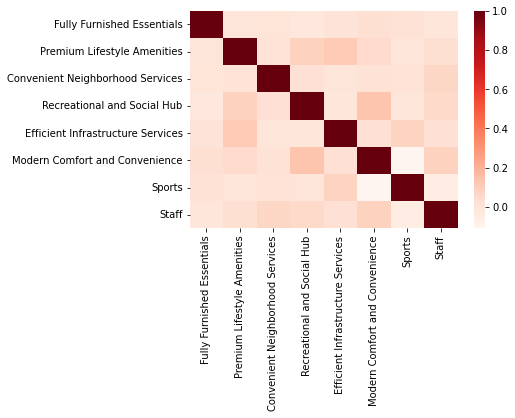

In [80]:
sns.heatmap(fscore_data.corr(), cmap='Reds')

In [81]:
vif_data = pd.DataFrame()
vif_data["Feature"] = fscore_data.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(fscore_data.values, i)
                          for i in range(len(fscore_data.columns))]
  
vif_data

,Feature,VIF
0,Fully Furnished Essentials,1.002024
1,Premium Lifestyle Amenities,1.021837
2,Convenient Neighborhood Services,1.005447
3,Recreational and Social Hub,1.026977
4,Efficient Infrastructure Services,1.019734
5,Modern Comfort and Convenience,1.038713
6,Sports,1.020929
7,Staff,1.015333


### Dropping Factorized variables

In [82]:
df.drop(columns = df.columns[9:], inplace=True)

In [83]:
df.head()

,Type,Floorsize,Carpet_area,Price_per_sqft,Price,Status,No_Of_Bathrooms,Furnishing_status,Locality
0,1.0,500.0,411.0,40000.0,20000000.0,1,2.0,0,12
1,1.0,515.0,480.0,4271.0,2200000.0,1,1.0,1,3
2,1.0,750.0,490.0,6266.0,4700000.0,0,2.0,0,3
3,1.0,640.0,448.0,5000.0,3200000.0,0,2.0,0,3
4,1.0,661.0,490.0,6959.0,4600000.0,0,2.0,0,3


### Splitting data into response and predictors

In [84]:
X, y = df.drop('Price', axis=1), df['Price']

In [85]:
X.head()

,Type,Floorsize,Carpet_area,Price_per_sqft,Status,No_Of_Bathrooms,Furnishing_status,Locality
0,1.0,500.0,411.0,40000.0,1,2.0,0,12
1,1.0,515.0,480.0,4271.0,1,1.0,1,3
2,1.0,750.0,490.0,6266.0,0,2.0,0,3
3,1.0,640.0,448.0,5000.0,0,2.0,0,3
4,1.0,661.0,490.0,6959.0,0,2.0,0,3


In [86]:
y.head()

0    20000000.0
1     2200000.0
2     4700000.0
3     3200000.0
4     4600000.0
Name: Price, dtype: float64

### Standardizing input variables

In [87]:
sc = StandardScaler()
X_std = sc.fit_transform(X)

In [88]:
X_std = pd.DataFrame(X_std, columns=X.columns)

In [89]:
X_std.head()

,Type,Floorsize,Carpet_area,Price_per_sqft,Status,No_Of_Bathrooms,Furnishing_status,Locality
0,-1.227156,-0.763227,-0.687814,1.082842,0.925933,-0.360545,-0.654957,0.740086
1,-1.227156,-0.743662,-0.571967,-1.480726,0.925933,-1.469058,0.934398,-0.878070
2,-1.227156,-0.437146,-0.555178,-1.337584,-1.079991,-0.360545,-0.654957,-0.878070
3,-1.227156,-0.580622,-0.625694,-1.428420,-1.079991,-0.360545,-0.654957,-0.878070
4,-1.227156,-0.553231,-0.555178,-1.287861,-1.079991,-0.360545,-0.654957,-0.878070


### Factor on Std variable

In [90]:
vif_data = pd.DataFrame()
vif_data["Feature"] = X_std.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X_std.values, i)
                          for i in range(len(X_std.columns))]
  
vif_data

,Feature,VIF
0,Type,4.350060
1,Floorsize,21.283215
2,Carpet_area,21.958531
3,Price_per_sqft,1.419054
4,Status,1.267779
5,No_Of_Bathrooms,3.994286
6,Furnishing_status,1.209170
7,Locality,1.020619


In [91]:
chi_sq, p_value = calculate_bartlett_sphericity(X_std)
chi_sq
print("Chi_sq: {}, p-value: {}".format(chi_sq, p_value))

Chi_sq: 51618.57972889536, p-value: 0.0


In [92]:
kmo_all,kmo_model=calculate_kmo(X_std)

In [93]:
kmo_model

0.7446861464746365

In [94]:
from factor_analyzer import FactorAnalyzer

fa = FactorAnalyzer()
fa.fit(X_std)

# Check Eigenvalues
ev, v = fa.get_eigenvalues()
ev

array([3.67830347, 1.48103122, 0.94580318, 0.78590942, 0.58373093,
       0.35271118, 0.14867354, 0.02383706])

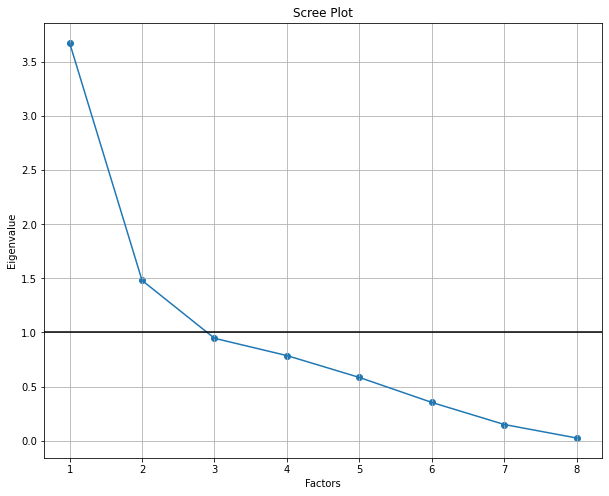

In [95]:
plt.figure(figsize=(10,8))
plt.scatter(range(1,X_std.shape[1]+1),ev)
plt.plot(range(1,X_std.shape[1]+1),ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.axhline(y=1,c='k')
plt.show()

In [96]:
fa_v = FactorAnalyzer(2, rotation="equamax")
fa_v.fit(X_std)
loadsvarimax = fa_v.loadings_
loadsvarimax_data = pd.DataFrame(loadsvarimax)
loadsvarimax_data.head()

,0,1
0,0.889935,-0.072579
1,0.909941,0.150255
2,0.933303,0.125031
3,0.433285,-0.170295
4,0.104556,0.708889


In [97]:
loadsvarimax_data.index = X_std.columns

In [98]:
factor_result = loadsvarimax_data.style.highlight_max(color = 'lightblue', axis = 1)
factor_result.to_excel('factor.xlsx', engine='openpyxl', index=True)

In [99]:
factor_result

,0,1
Type,0.889935,-0.072579
Floorsize,0.909941,0.150255
Carpet_area,0.933303,0.125031
Price_per_sqft,0.433285,-0.170295
Status,0.104556,0.708889
No_Of_Bathrooms,0.868549,-0.150582
Furnishing_status,0.119148,0.513072
Locality,-0.012550,-0.173330


In [100]:
fscore = fa_v.transform(X_std)
fscore_data1 = pd.DataFrame(fscore, columns=["House dynamics", "House Status"])
fscore_data1.head()

,House dynamics,House Status
0,-0.775051,0.244479
1,-0.982165,1.197008
2,-0.724337,-0.510160
3,-0.760820,-0.550258
4,-0.718320,-0.548206


In [114]:
df_merged = pd.concat([fscore_data1,fscore_data], axis=1)
df_merged

,House dynamics,House Status,Fully Furnished Essentials,Premium Lifestyle Amenities,Convenient Neighborhood Services,Recreational and Social Hub,Efficient Infrastructure Services,Modern Comfort and Convenience,Sports,Staff
0,-0.775051,0.244479,-0.339110,-1.598730,-0.118502,-0.309949,1.027567,-0.153160,0.296538,-0.126421
1,-0.982165,1.197008,0.101872,-1.286364,-0.268209,-0.314484,-1.581264,1.264598,-0.283176,0.180845
2,-0.724337,-0.510160,-0.351610,-0.968535,3.906520,-0.564554,0.411690,0.680239,-1.883585,-0.847601
3,-0.760820,-0.550258,-0.265031,-0.228875,-0.138472,0.271288,-2.198463,-0.714652,-0.088757,-0.345995
4,-0.718320,-0.548206,-0.349487,0.347172,0.153181,0.504245,0.451667,-0.007828,1.322632,-0.261523
...,...,...,...,...,...,...,...,...,...,...
8862,13.702248,2.795682,3.535425,0.613200,-0.609903,0.168843,-0.631466,1.994288,0.002208,-0.535416
8863,6.410565,0.445798,3.993229,-0.727641,-0.243227,-0.268344,0.408523,-0.216509,-0.116987,-0.445043
8864,9.362808,1.313614,3.986942,0.981527,-0.660367,1.315534,0.005487,1.181605,-0.090290,-0.345696
8865,8.501811,0.557086,3.998331,-1.280458,-0.215959,-0.098141,0.535263,-0.019671,-0.154929,-0.252435


In [102]:
df_merged['Premium Lifestyle Amenities'].std()

0.9305327627392994

In [103]:
X_fact = df_merged.copy()

### Train test split

In [104]:
X_train, X_test, y_train, y_test = train_test_split(X_fact, y, random_state=0, test_size=.2)

### Linear Regression

#### LR2

In [105]:
lr1 = LinearRegression()
lr1.fit(X_train, y_train)

LinearRegression()

In [106]:
pred_lr = lr1.predict(X_test)
diff_lr1 = pd.DataFrame({'Actual':y_test, 'Predicted': pred_lr})
diff_lr1.head()

,Actual,Predicted
8132,25000000.0,5.488036e+07
6137,33500000.0,4.648017e+07
3327,17500000.0,1.012435e+07
7969,39900000.0,4.850450e+07
6645,38300000.0,4.556497e+07


In [107]:
print("Intercept: {}\n".format(lr1.intercept_))
print("Coefficients: {}".format(lr1.coef_))

Intercept: 30370673.76462752

Coefficients: [31208630.40817058  2225584.63915437  1273008.63667077 -2018586.42979743
 -1105723.14900473  1048404.87632648  -319474.70531274  -530781.6018558
 -2981557.60426166 -2059134.04741942]


In [108]:
print("Training Score: {}".format(lr1.score(X_train, y_train)))
print("Testing Score: {}".format(lr1.score(X_test, y_test)))

Training Score: 0.7143600125053733
Testing Score: 0.6680783997097264


In [109]:
lr1.intercept_

30370673.76462752

In [110]:
lr1.coef_

array([31208630.40817058,  2225584.63915437,  1273008.63667077,
       -2018586.42979743, -1105723.14900473,  1048404.87632648,
        -319474.70531274,  -530781.6018558 , -2981557.60426166,
       -2059134.04741942])

In [111]:
X_fact

,House dynamics,House Status,Fully Furnished Essentials,Premium Lifestyle Amenities,Convenient Neighborhood Services,Recreational and Social Hub,Efficient Infrastructure Services,Modern Comfort and Convenience,Sports,Staff
0,-0.775051,0.244479,-0.339110,-1.598730,-0.118502,-0.309949,1.027567,-0.153160,0.296538,-0.126421
1,-0.982165,1.197008,0.101872,-1.286364,-0.268209,-0.314484,-1.581264,1.264598,-0.283176,0.180845
2,-0.724337,-0.510160,-0.351610,-0.968535,3.906520,-0.564554,0.411690,0.680239,-1.883585,-0.847601
3,-0.760820,-0.550258,-0.265031,-0.228875,-0.138472,0.271288,-2.198463,-0.714652,-0.088757,-0.345995
4,-0.718320,-0.548206,-0.349487,0.347172,0.153181,0.504245,0.451667,-0.007828,1.322632,-0.261523
...,...,...,...,...,...,...,...,...,...,...
8862,13.702248,2.795682,3.535425,0.613200,-0.609903,0.168843,-0.631466,1.994288,0.002208,-0.535416
8863,6.410565,0.445798,3.993229,-0.727641,-0.243227,-0.268344,0.408523,-0.216509,-0.116987,-0.445043
8864,9.362808,1.313614,3.986942,0.981527,-0.660367,1.315534,0.005487,1.181605,-0.090290,-0.345696
8865,8.501811,0.557086,3.998331,-1.280458,-0.215959,-0.098141,0.535263,-0.019671,-0.154929,-0.252435


In [112]:
sd_x = X_fact.std()
sd_y = y.std()
beta_coefficients = []

# Iterate through independent variables and calculate beta coefficients
for i, col in enumerate(X_fact.columns):
    beta = lr1.coef_[i] * (sd_x[col] / sd_y)
    beta_coefficients.append([col, beta])

# Print beta coefficients
for var, beta in beta_coefficients:
    print(f' {var}: {beta}')

 House dynamics: 0.8525277871855907
 House Status: 0.04966101680861978
 Fully Furnished Essentials: 0.03473743001352761
 Premium Lifestyle Amenities: -0.05248571927838486
 Convenient Neighborhood Services: -0.029218753457542684
 Recreational and Social Hub: 0.02481966822687762
 Efficient Infrastructure Services: -0.0076922053876087365
 Modern Comfort and Convenience: -0.011599336065142843
 Sports: -0.07077731732999532
 Staff: -0.04758754718746644


In [115]:
# pd.DataFrame({'coef':lr1.coef_}, index=lr1.feature_names_in_).to_excel('secondary_coef.xlsx')

### Checking Assumptions of Linear regression

#### Normality of residuals

In [116]:
residuals_lr = y_test - pred_lr

In [117]:
sorted_vals = residuals_lr.sort_values()
residual1 = sorted_vals.iloc[3:]
residual1

8780   -7.782290e+07
8753   -7.415890e+07
7369   -6.924976e+07
6601   -6.898940e+07
6605   -6.813651e+07
            ...     
8690    1.139290e+08
7193    1.163465e+08
8667    1.323798e+08
8682    1.392929e+08
8853    1.675193e+08
Name: Price, Length: 1771, dtype: float64

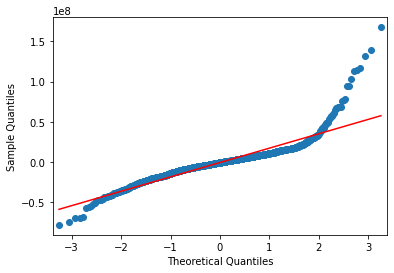

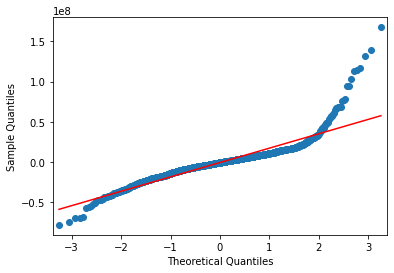

In [118]:
qqplot(residual1, line = 's')

<AxesSubplot:xlabel='Price', ylabel='Density'>

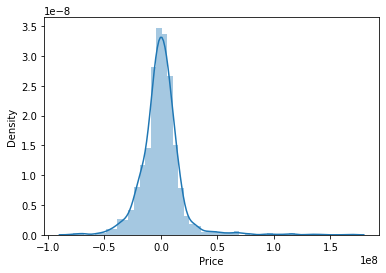

In [119]:
sns.distplot(residual1)

In [120]:
residual1.mean()

-376473.6402253115

In [121]:
stat, p = shapiro(residuals_lr)
print('Shapiro-Wilk test for normality of WorkingHour:')
print(f'Statistics = {stat}, p-value = {p}')
if p > 0.05:
    print('The distribution is normal')
else:
    print('The distribution is not normal')

Shapiro-Wilk test for normality of WorkingHour:
Statistics = 0.7339839935302734, p-value = 0.0
The distribution is not normal


### Homoscedasticity

<AxesSubplot:xlabel='Price', ylabel='Price'>

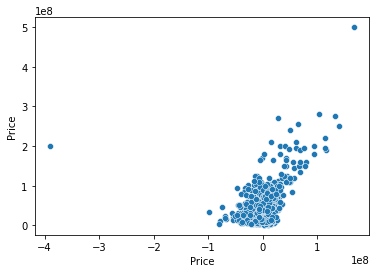

In [122]:
sns.scatterplot(residuals_lr, y_test)

In [123]:
residuals_lr

8132   -2.988036e+07
6137   -1.298017e+07
3327    7.375652e+06
7969   -8.604503e+06
6645   -7.264967e+06
            ...     
5449   -6.715940e+06
8585    2.903243e+07
3444   -2.225446e+07
1081    1.493821e+07
7968   -2.370822e+07
Name: Price, Length: 1774, dtype: float64

### Ridge Regression

In [124]:
from sklearn.linear_model import Ridge

ridreg = Ridge(alpha=20.0).fit(X_train, y_train)
print('House Price')
print('Ridge regression intercept:', ridreg.intercept_)
print('Ridge regression coefficients:', ridreg.coef_)
print('Training score {:.3f}'.format(ridreg.score(X_train, y_train)))
print('Testing score {:.3f}'.format(ridreg.score(X_test, y_test)))

House Price
Ridge regression intercept: 30370090.322072715
Ridge regression coefficients: [31108872.67417666  2205021.92492408  1288612.47941205 -2009308.62948872
 -1104224.08689012  1054779.36819916  -317902.05382234  -524688.55960304
 -2961646.48856487 -2041590.22534019]
Training score 0.714
Testing score 0.669


In [125]:
# Effect alpha regularization

alpha = [0, 1, 10, 20, 50, 100, 1000, 2000]
for i in alpha:
    linridge = Ridge(alpha=i).fit(X_train, y_train)
    r2_train = linridge.score(X_train, y_train)
    r2_test = linridge.score(X_test, y_test)
    num_coeff_big = np.sum(abs(linridge.coef_)>1.0)
    
    print('Alpha : {:.2f}\nnumber of non-zero features: {} r_sq_train: {:.4f}, r_sq_test: {:.4f}\n'.format(i,num_coeff_big,r2_train,r2_test))

Alpha : 0.00
number of non-zero features: 10 r_sq_train: 0.7144, r_sq_test: 0.6681

Alpha : 1.00
number of non-zero features: 10 r_sq_train: 0.7144, r_sq_test: 0.6681

Alpha : 10.00
number of non-zero features: 10 r_sq_train: 0.7144, r_sq_test: 0.6684

Alpha : 20.00
number of non-zero features: 10 r_sq_train: 0.7144, r_sq_test: 0.6687

Alpha : 50.00
number of non-zero features: 10 r_sq_train: 0.7143, r_sq_test: 0.6696

Alpha : 100.00
number of non-zero features: 10 r_sq_train: 0.7142, r_sq_test: 0.6711

Alpha : 1000.00
number of non-zero features: 10 r_sq_train: 0.7014, r_sq_test: 0.6801

Alpha : 2000.00
number of non-zero features: 10 r_sq_train: 0.6747, r_sq_test: 0.6684



In [126]:
ridge = Ridge(alpha=1000).fit(X_train, y_train)

In [127]:
pred_ridge = ridge.predict(X_test)
pred_ridge

array([52617036.87965927, 44968962.06226154, 12654652.65577155, ...,
       25188836.01037189,  3091907.06275677, 65930273.77266733])

### Lasso Regression

In [128]:
from sklearn.linear_model import Lasso

ridreg = Lasso(alpha=20.0).fit(X_train, y_train)
print('House Price')
print('Ridge regression intercept:', ridreg.intercept_)
print('Ridge regression coefficients:', ridreg.coef_)
print('Training score {:.3f}'.format(ridreg.score(X_train, y_train)))
print('Testing score {:.3f}'.format(ridreg.score(X_test, y_test)))

House Price
Ridge regression intercept: 30370673.63573787
Ridge regression coefficients: [31208609.93005067  2225527.87307431  1273003.05287976 -2018576.06350091
 -1105696.407198    1048366.31247087  -319449.88391797  -530741.90546812
 -2981513.58052567 -2059095.26635088]
Training score 0.714
Testing score 0.668


In [129]:
alpha = [0.5, 1, 2, 3, 5, 10, 20, 50, 100, 1000]
for i in alpha:
    linlasso = Lasso(i,max_iter=10000).fit(X_train, y_train)
    r2_train = linlasso.score(X_train, y_train)
    r2_test = linlasso.score(X_test, y_test)
    print('Alpha: {:.2f}\nTrain_score: {:.4f}  Test_score: {:.4f}\n'.format(i, r2_train, r2_test))

Alpha: 0.50
Train_score: 0.7144  Test_score: 0.6681

Alpha: 1.00
Train_score: 0.7144  Test_score: 0.6681

Alpha: 2.00
Train_score: 0.7144  Test_score: 0.6681

Alpha: 3.00
Train_score: 0.7144  Test_score: 0.6681

Alpha: 5.00
Train_score: 0.7144  Test_score: 0.6681

Alpha: 10.00
Train_score: 0.7144  Test_score: 0.6681

Alpha: 20.00
Train_score: 0.7144  Test_score: 0.6681

Alpha: 50.00
Train_score: 0.7144  Test_score: 0.6681

Alpha: 100.00
Train_score: 0.7144  Test_score: 0.6681

Alpha: 1000.00
Train_score: 0.7144  Test_score: 0.6681



In [130]:
lasso = Lasso(alpha=1000).fit(X_train, y_train)

In [131]:
pred_lasso = lasso.predict(X_test)
pred_lasso

array([54880768.89341357, 46480537.54831073, 10128525.89095608, ...,
       25151837.17665181, -1181245.76651195, 70201272.43188529])

### Decision Trees

##### Overfitted model

In [132]:
DT = DecisionTreeRegressor(random_state=0)
DT.fit(X_train, y_train)

DecisionTreeRegressor(random_state=0)

In [133]:
pred = DT.predict(X_test)
pred

array([25000000., 26900000., 19500000., ..., 16000000., 17408000.,
       97500000.])

In [134]:
DT.score(X_train, y_train)

0.9999999999997345

In [135]:
r2_score(y_test, pred)

0.671932549973361

#### Pruning decision tree

In [136]:
# Checking model performance on different

for i in range(1,10,1):
    DT = DecisionTreeRegressor(max_depth=i, random_state=0)
    DT.fit(X_train, y_train)
    print("Max-depth: {}\nTrainnig_Score: {:.4f}\nTesting_Score: {:.4f}".format(i,DT.score(X_train, y_train),r2_score(y_test, pred)))
    print("=====================================")

Max-depth: 1
Trainnig_Score: 0.4345
Testing_Score: 0.6719
Max-depth: 2
Trainnig_Score: 0.6471
Testing_Score: 0.6719
Max-depth: 3
Trainnig_Score: 0.7412
Testing_Score: 0.6719
Max-depth: 4
Trainnig_Score: 0.7844
Testing_Score: 0.6719
Max-depth: 5
Trainnig_Score: 0.8126
Testing_Score: 0.6719
Max-depth: 6
Trainnig_Score: 0.8378
Testing_Score: 0.6719
Max-depth: 7
Trainnig_Score: 0.8574
Testing_Score: 0.6719
Max-depth: 8
Trainnig_Score: 0.8826
Testing_Score: 0.6719
Max-depth: 9
Trainnig_Score: 0.9022
Testing_Score: 0.6719


In [137]:
DT_depth6 = DecisionTreeRegressor(random_state=0, max_depth=6)
DT_depth6.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=6, random_state=0)

In [138]:
pred_dt = DT_depth6.predict(X_test)
pred_dt

array([36000000.        , 32135884.17592593, 13350076.5389948 , ...,
       17736773.27537923,  8722449.41268598, 61776347.90584416])

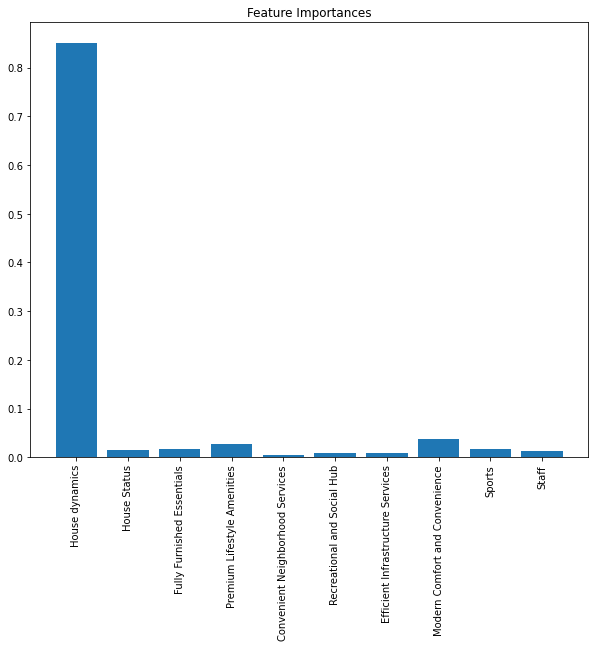

In [139]:
plt.figure(figsize=(10,8))
plt.bar(range(len(DT.feature_importances_)), DT.feature_importances_)
plt.xticks(range(len(DT.feature_importances_)), DT.feature_names_in_, rotation=90)
plt.title("Feature Importances")
plt.show()

In [ ]:
from sklearn.tree import export_graphviz
import pydotplus

# Export resulting tree to DOT source code string
dot_data = export_graphviz(DT,
                           feature_names=DT.feature_names_in_,
                           out_file=None,
                           filled=True,
                           rounded=True)

# Export to pdf
pydot_graph = pydotplus.graph_from_dot_data(dot_data)
pydot_graph.write_pdf('DT_max_depth5.pdf')

### Random forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

In [ ]:
pred_rf = rf.predict(X_test)
pred_rf

In [ ]:
rf.score(X_train, y_train)

In [ ]:
rf.score(X_test, y_test)

### Summary of all models

In [ ]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

In [ ]:
models = ['Linear regression', 'Ridge Regression', 'Lasso Regression', 'DecisionTree Regressor', 'Random Forest']
l = [pred_lr,pred_ridge,pred_lasso,pred_dt,pred_rf]
l1=[]
for model in l:
    l1.append({'R2 score':r2_score(y_test, model), 'MAE':mean_absolute_error(y_test, model),
                            'MAPE':mean_absolute_percentage_error(y_test, model), 
                            'MSE':mean_squared_error(y_test, model),
                            'RMSE':np.sqrt(mean_squared_error(y_test, model))
                    })
summary_models = pd.DataFrame(l1, index=models)
summary_models

In [ ]:
summary_models.to_excel('Metrics/all_metric_secondary.xlsx')